In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

from matplotlib import pyplot as plt

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show


import scipy
from scipy.signal import argrelextrema
from scipy import stats as stats
from scipy import optimize
import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline

/Users/JFrank/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:4: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  from matplotlib.artist import setp


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

from math import sqrt
SPINE_COLOR = 'gray'

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': '\\usepackage{gensymb}',
              'axes.labelsize': 20, # fontsize for x and y labels (was 10)
              'axes.titlesize': 20,
              'font.size': 20, # was 10
              'legend.fontsize': 20, # was 10
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'text.usetex': False,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif',
              'axes.formatter.limits': [-3, 3],
              'axes.formatter.use_mathtext': True,
    }

    
    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [4]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    Exp: Lie Transfer Map gets applied
    BCH: Baker- Campbell - Hausdorff expansion gets applied as Lie Tranfer Map concatenation
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
    
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)
    
    #Define Substraction
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rsub__')
    def __sub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__sub__')
    def __rsub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            other = LieOperator(other,self.indep_coords,self.indep_mom) 
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform Map
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    #Up to order 4 done manually to have a working copy, arbitrary ordered needs to be still written
    def BCH(self,other,n):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        elif n < 1:
            raise ValueError(n, ' is not a valid order. Number has to be natural.')
            
        _op1 = LieOperator(self.ham,self.indep_coords, self.indep_mom)
        _op2 = LieOperator(other.ham, other.indep_coords, other.indep_mom)
        
        
        temp = _op1 + _op2
        
        if n > 1:
            _xy = _op1 * _op2
            _yx = _op2 * _op1
            temp = temp + sympy.Rational(1,2) * _xy
        
        if n > 2:
            _xxy = _op1 * _xy
            _yyx = _op2 * _yx
            temp = temp + sympy.Rational(1,12) * _xxy + sympy.Rational(1,12) * _yyx
           
        if n > 3:
            _yxxy = _op2 * _xxy 
            temp = temp  - sympy.Rational(1,24) * _yxxy
        
        if n > 4:
            _xyxyx = _op1 * (_op2 * (_op1 * _yx))
            _yxyxy = _op2 * (_op1 * (_op2 * _xy))
            
            _xxxy = _op1 * _xxy
            _yyyx = _op2 * _yyx
            temp = temp + (sympy.Rational(1,120) * _xyxyx
                           + sympy.Rational(1,120) * _yxyxy
                           + sympy.Rational(1,360) * _op1 * _yyyx
                           + sympy.Rational(1,360) * _op2 * _xxxy
                           - sympy.Rational(1,720) * _op2 * _yyyx
                           - sympy.Rational(1,720) * _op1 * _xxxy
                          )
        
#         temp = _op1 + _op2
        
#         if n > 1:
#             temp = temp + sympy.Rational(1,2) * _op1 * _op2
        
#         if n > 2:
#             temp = temp + sympy.Rational(1,12) * _op1 * (_op1 * _op2) + sympy.Rational(1,12) * _op2 * (_op2 * _op1)
           
#         if n > 3:
#             temp = temp  + sympy.Rational(1,24) * _op2 * (_op1 * (_op2 * _op1))
        
#         if n > 4:
#             temp = temp + (sympy.Rational(1,120) * _op2 * (_op1 * (_op2 * (_op1 * _op2)))
#                            + sympy.Rational(1,120) * _op1 * (_op2 * (_op1 * (_op2 * _op1)))
#                            + sympy.Rational(1,360) * _op1 * (_op2 * (_op2 * (_op2 * _op1)))
#                            + sympy.Rational(1,360) * _op2 * (_op1 * (_op1 * (_op1 * _op2)))
#                            - sympy.Rational(1,720) * _op2 * (_op2 * (_op2 * (_op2 * _op1)))
#                            - sympy.Rational(1,720) * _op1 * (_op1 * (_op1 * (_op1 * _op2)))
#                           )
       
        return temp

In [5]:
l1 = 0
l2 = 0.5
l3 = 1.5
l4 = 2.5
l5 = 1.5
l6 = 0.5
l7 = 0

k2 = 0.54102
k4 = k2/2
k6 = k2

omegaf = np.sqrt(k2)
_sinf = np.sin(omegaf * l2)
_cosf = np.cos(omegaf * l2)
_sinhf = np.sinh(omegaf * l2)
_coshf = np.cosh(omegaf * l2)

Mqf = np.array(
    [
        [_cosf, _sinf / omegaf, 0, 0],
        [-omegaf * _sinf, _cosf, 0, 0],
        [0, 0, _coshf, _sinhf / omegaf],
        [0, 0, omegaf * _sinhf, _coshf]
    ]
)

omegad = np.sqrt(k4)
_sind = np.sin(omegad * l4)
_cosd = np.cos(omegad * l4)
_sinhd = np.sinh(omegad * l4)
_coshd = np.cosh(omegad * l4)
Mqd = np.array(
    [
        [_coshd,_sinhd / omegad, 0, 0],
        [omegad * _sinhd, _coshd, 0, 0],
        [0, 0, _cosd, _sind / omegad],
        [0, 0, -omegad * _sind, _cosd]
    ]
)


Md = np.array(
    [
        [1,l3,0,0],
        [0,1,0,0],
        [0,0,1,l3],
        [0,0,0,1]
    ]
)

M = np.dot(Md,Mqf)
M = np.dot(Mqd,M)
M = np.dot(Md,M)
M = np.dot(Mqf,M)

r0 = np.array([10e-5,0,10e-4,0])
dataMATRICES = [r0]

duration = 100

for i in range(duration):
    r = np.dot(M,r0)
    dataMATRICES.append(r)
    r0 = np.copy(r)

dataMATRICES = np.array(dataMATRICES)

In [6]:
sym_x, sym_px, sym_y, sym_py, sym_k1, sym_k2, sym_l, sym_l1, sym_l2 = sympy.symbols('x p_x y p_y k_1 k_2 L L_1 L_2')
sym_f = -sym_l1 * sympy.Rational(1,2) * ((sym_px**2 + sym_py**2) + sym_k1*(sym_x**2 - sym_y**2))
sym_df = -sym_l2 * sympy.Rational(1,2) * ((sym_px**2 + sym_py**2) + sym_k2*(sym_x**2 - sym_y**2))
sym_drift = - sym_l * sympy.Rational(1,2) * (sym_px**2 + sym_py**2)

lief = LieOperator(sym_f,[sym_x,sym_y],[sym_px,sym_py])
lied = LieOperator(sym_drift,[sym_x,sym_y],[sym_px,sym_py])
liedf = LieOperator(sym_df,[sym_x,sym_y],[sym_px,sym_py])

In [6]:
def z_funcx(X,P,level,el):
    
    if el == 1:
        lint = lief.BCH(lied,level)
        sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_y:0,sym_py:0}
        ).doit().expand()
    elif el == 2:
        lint = lied.BCH(liedf,level)
        lint2 = lief.BCH(lint,level)
        sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_y:0,sym_py:0}
        ).doit().expand()
    elif el == 3:
        lint = liedf.BCH(lied,level)
        lint2 = lied.BCH(lint,level)
        lint3 = lief.BCH(lint2,level)
        sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_y:0,sym_py:0}
        ).doit().expand()
    elif el == 4:
        lint = lied.BCH(lief,level)
        lint2 = liedf.BCH(lint,level)
        lint3 = lied.BCH(lint2,level)
        lint4 = lief.BCH(lint3,level)
        sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_y:0,sym_py:0}
        ).doit().expand()
    np_f = lambdify([sym_x,sym_px], sym_test, 'numpy')
    return np_f(X,P)




def z_funcy(X,P,level,el):

    if el == 1:
        lint = lief.BCH(lied,level)
        sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
    elif el == 2:
        lint = lied.BCH(liedf,level)
        lint2 = lief.BCH(lint,level)
        sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
    elif el == 3:
        lint = liedf.BCH(lied,level)
        lint2 = lied.BCH(lint,level)
        lint3 = lief.BCH(lint2,level)
        sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
    elif el == 4:
        lint = lied.BCH(lief,level)
        lint2 = liedf.BCH(lint,level)
        lint3 = lied.BCH(lint2,level)
        lint4 = lief.BCH(lint3,level)
        sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
    np_f = lambdify([sym_y,sym_py], sym_test, 'numpy')
    return np_f(X,P)

In [7]:
# setting up plotd
grid_delta = 0.000001
grid_q = arange(-0.002,0.002,grid_delta)
grid_p = arange(-0.002,0.002,grid_delta)
Q, P = np.meshgrid(grid_q, grid_p)

In [8]:
order = 5
el = 4
levelsx = [z_funcx(10e-5,0,order,el)]
levelsy = [z_funcy(10e-4,0,order,el)]
levels = [levelsx,levelsy]

Zx = z_funcx(Q,P,order,el)
Zy = z_funcy(Q,P,order,el)
Zvals = [Zx,Zy]

titles = ['(x,px)','(y,py)']

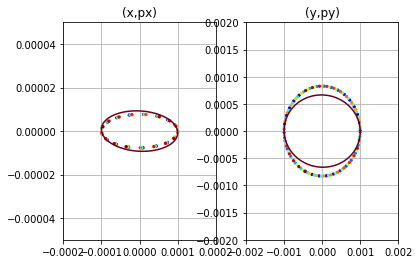

In [9]:
fig, axes = plt.subplots(1,2, sharey=False)

for i,ax in enumerate(axes):
    ax.contour(Q,P,Zvals[i], levels[i],cmap=cm.RdBu)
    ax.grid()
    ax.scatter(dataMATRICES[:,2*i],dataMATRICES[:,2*i+1],s=5,c=range(dataMATRICES.shape[0]),cmap='jet')
#                 cmap=cm.get_cmap(cmap, len(levels)-1),
#                 norm=norm)
#     ax.autoscale(False) # To avoid that the scatter changes limits
#     ax.scatter(np.random.uniform(-3,3,10),
#                np.random.uniform(-2,2,10),
#                zorder=zord)
    ax.set_title(titles[i])
    
axes[0].set_xlim(-0.0002,0.0002);
axes[0].set_ylim(-0.00005,0.00005);

# Element by Element

In [10]:
l1 = 0
l2 = 0.5
l3 = 1.5
l4 = 2.5
l5 = 1.5
l6 = 0.5
l7 = 0

k2 = 0.54102
k4 = k2/2
k6 = k2

omegaf = np.sqrt(k2)
_sinf = np.sin(omegaf * l2)
_cosf = np.cos(omegaf * l2)
_sinhf = np.sinh(omegaf * l2)
_coshf = np.cosh(omegaf * l2)

Mqf = np.array(
    [
        [_cosf, _sinf / omegaf, 0, 0],
        [-omegaf * _sinf, _cosf, 0, 0],
        [0, 0, _coshf, _sinhf / omegaf],
        [0, 0, omegaf * _sinhf, _coshf]
    ]
)

omegad = np.sqrt(k4)
_sind = np.sin(omegad * l4)
_cosd = np.cos(omegad * l4)
_sinhd = np.sinh(omegad * l4)
_coshd = np.cosh(omegad * l4)
Mqd = np.array(
    [
        [_coshd,_sinhd / omegad, 0, 0],
        [omegad * _sinhd, _coshd, 0, 0],
        [0, 0, _cosd, _sind / omegad],
        [0, 0, -omegad * _sind, _cosd]
    ]
)


Md = np.array(
    [
        [1,l3,0,0],
        [0,1,0,0],
        [0,0,1,l3],
        [0,0,0,1]
    ]
)

M = Mqf
M = np.dot(Md,Mqf)
M = np.dot(Mqd,M)
M = np.dot(Md,M)
M = np.dot(Mqf,M)

r0 = np.array([10e-5,0,10e-4,0])
dataMATRICES = [r0]

duration = 1

for i in range(duration):
    r = np.dot(M,r0)
    _rint = np.dot(Mqf,r0)
    _rint2 = np.dot(Md,_rint)
    _rint3 = np.dot(Mqd,_rint2)
    _rint4 = np.dot(Md,_rint3)
    
    dataMATRICES.append(_rint)
    dataMATRICES.append(_rint2)
    dataMATRICES.append(_rint3)
    dataMATRICES.append(_rint4)
    dataMATRICES.append(r)
    r0 = np.copy(r)

dataMATRICES = np.array(dataMATRICES)

In [11]:
order = 5
el = 4
levelsx = [z_funcx(10e-5,0,order,el)]
levelsy = [z_funcy(10e-4,0,order,el)]
levels = [levelsx,levelsy]

Zx = z_funcx(Q,P,order,el)
Zy = z_funcy(Q,P,order,el)
Zvals = [Zx,Zy]

titles = ['(x,px)','(y,py)']

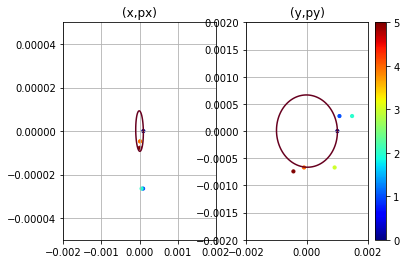

In [12]:
fig, axes = plt.subplots(1,2, sharey=False)
XYCONT = []
for i,ax in enumerate(axes):
    cont = ax.contour(Q,P,Zvals[i], levels[i],cmap=cm.RdBu)
    XYCONT.append(cont)
    ax.grid()
    sp = ax.scatter(dataMATRICES[:,2*i],dataMATRICES[:,2*i+1],s=10,c=range(dataMATRICES.shape[0]),cmap='jet')
#                 cmap=cm.get_cmap(cmap, len(levels)-1),
#                 norm=norm)
#     ax.autoscale(False) # To avoid that the scatter changes limits
#     ax.scatter(np.random.uniform(-3,3,10),
#                np.random.uniform(-2,2,10),
#                zorder=zord)
    ax.set_title(titles[i])
plt.colorbar(sp)
axes[0].set_xlim(-0.002,0.002)
axes[0].set_ylim(-0.00005,0.00005)

# Element by Element Ellipse Tracking

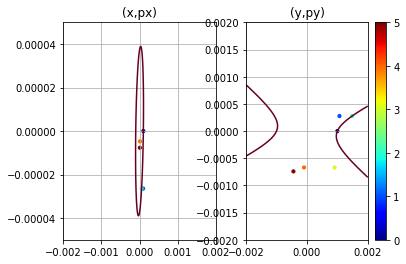

In [13]:
order = 4
el = 1
levelsx = [z_funcx(10e-5,0,order,el)]
levelsy = [z_funcy(10e-4,0,order,el)]
levels = [levelsx,levelsy]

Zx = z_funcx(Q,P,order,el)
Zy = z_funcy(Q,P,order,el)
Zvals = [Zx,Zy]

titles = ['(x,px)','(y,py)']

fig, axes = plt.subplots(1,2, sharey=False)
XYCONT = []
for i,ax in enumerate(axes):
    cont = ax.contour(Q,P,Zvals[i], levels[i],cmap=cm.RdBu)
    XYCONT.append(cont)
    ax.grid()
    sp = ax.scatter(dataMATRICES[:,2*i],dataMATRICES[:,2*i+1],s=10,c=range(dataMATRICES.shape[0]),cmap='jet')
#                 cmap=cm.get_cmap(cmap, len(levels)-1),
#                 norm=norm)
#     ax.autoscale(False) # To avoid that the scatter changes limits
#     ax.scatter(np.random.uniform(-3,3,10),
#                np.random.uniform(-2,2,10),
#                zorder=zord)
    ax.set_title(titles[i])
plt.colorbar(sp)
axes[0].set_xlim(-0.002,0.002)
axes[0].set_ylim(-0.00005,0.00005)

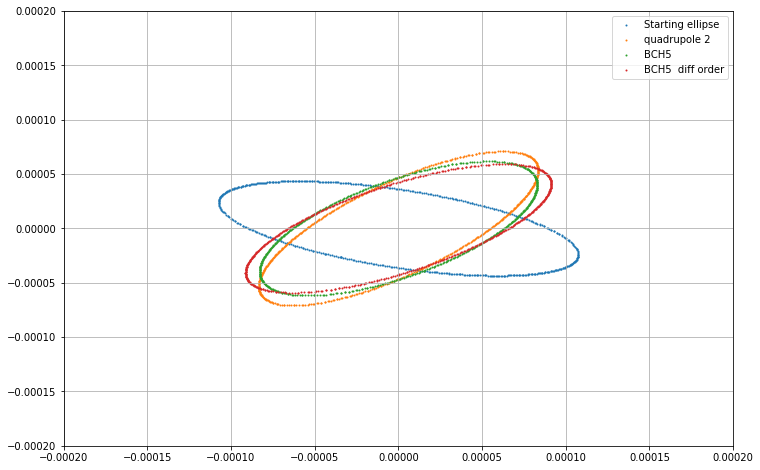

In [14]:
l1 = 0
l2 = 0.5
l3 = 1.5
l4 = 2.5
l5 = 1.5
l6 = 0.5
l7 = 0

k2 = 0.54102
k4 = k2/2
k6 = k2

omegaf = np.sqrt(k2)
_sinf = np.sin(omegaf * l2)
_cosf = np.cos(omegaf * l2)
_sinhf = np.sinh(omegaf * l2)
_coshf = np.cosh(omegaf * l2)


omegad = np.sqrt(k4)
_sind = np.sin(omegad * l4)
_cosd = np.cos(omegad * l4)
_sinhd = np.sinh(omegad * l4)
_coshd = np.cosh(omegad * l4)


Mqd = np.array(
    [
        [_cosd, _sind / omegad],
        [-omegad * _sind, _cosd]
    ]
)



Mqf = np.array(
    [[_coshf, _sinhf / omegaf],
        [omegaf * _sinhf, _coshf]
    ]
)


Mqfinv = np.array([[_coshf, -_sinhf / omegaf],
                   [-omegaf * _sinhf, _coshf]])

Md = np.array(
    [
        [1,l3],
        [0,1],
    ]
)




dat0= XYCONT[0].allsegs[0][0]

dataINIT = []

for i in dat0:
    rnew = np.dot(Mqfinv,i)
    dataINIT.append(rnew)
    
fig =plt.figure(figsize=(12,8))

dataINIT = np.asarray(dataINIT)
plt.scatter(dataINIT[:,0],dataINIT[:,1],s=1,cmap='jet',label='Starting ellipse')
plt.xlim(-0.00015,0.00015);
plt.ylim(-0.00015,0.00015);


# M = np.dot(Mqf,Mdinv)
M = Mqf

r0 = dataINIT
dataQUAD = []
    

for i in dataINIT:
    rnew = np.dot(M,i)
    dataQUAD.append(rnew)


dataQUAD = np.asarray(dataQUAD)


M = Md
# M = np.dot(Md, Mqf)

dataDRIFT = []

for i in dataQUAD:
    rnew = np.dot(M,i)
    dataDRIFT.append(rnew)

dataDRIFT = np.asarray(dataDRIFT)

M = Mqd
# M = np.dot(Md, Mqf)

dataQUADD = []

for i in dataDRIFT:
    rnew = np.dot(M,i)
    dataQUADD.append(rnew)

dataQUADD = np.asarray(dataQUADD)

M = Md
# M = np.dot(Md, Mqf)

dataDRIFT2 = []

for i in dataQUADD:
    rnew = np.dot(M,i)
    dataDRIFT2.append(rnew)

dataDRIFT2 = np.asarray(dataDRIFT2)


M = Mqf
# M = np.dot(Md, Mqf)

dataQUAD2 = []

for i in dataDRIFT2:
    rnew = np.dot(M,i)
    dataQUAD2.append(rnew)

dataQUAD2 = np.asarray(dataQUAD2)


# M = np.dot(Md,np.dot(Mqd,np.dot(Md,Mqf)))
# dataCheck = []
# for i in dataINIT:
#     rnew = np.dot(M,i)
#     dataCheck.append(rnew)

# dataCheck = np.asarray(dataCheck)


##### -----------------------------------LIE MAPS CONC--------------------------------------

level = 3
el = 4


if el == 1:
    lint = lief.BCH(lied,level)
    sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 2:
    lint = lied.BCH(liedf,level)
    lint2 = lief.BCH(lint,level)
    sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 3:
    lint = liedf.BCH(lied,level)
    lint2 = lied.BCH(lint,level)
    lint3 = lief.BCH(lint2,level)
    sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 4:
    lint = lied.BCH(lief,level)
    lint2 = liedf.BCH(lint,level)
    lint3 = lied.BCH(lint2,level)
    lint4 = lief.BCH(lint3,level)
    sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()


    
HAM3 = sym_test

a = -2*float(HAM3.coeff(sym_py**2))
b = -float(HAM3.coeff(sym_y*sym_py))
c = -2*float(HAM3.coeff(sym_y**2))
D = np.sqrt(np.abs(b**2 - a*c))

if b**2 - a*c < 0:
    R3 = np.array([[np.cos(D) + b*np.sin(D)/D, a*np.sin(D)/D],
            [-c*np.sin(D)/D, np.cos(D) - b*np.sin(D)/D]])
else:
    R3 = np.array([[np.cosh(D) + b*np.sinh(D)/D, a*np.sinh(D)/D],
            [-c*np.sinh(D)/D, np.cosh(D) - b*np.sinh(D)/D,]])
    
    
    

level = 4
el = 4


if el == 1:
    lint = lief.BCH(lied,level)
    sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 2:
    lint = lied.BCH(liedf,level)
    lint2 = lief.BCH(lint,level)
    sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 3:
    lint = liedf.BCH(lied,level)
    lint2 = lied.BCH(lint,level)
    lint3 = lief.BCH(lint2,level)
    sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 4:
    lint = lied.BCH(lief,level)
    lint2 = liedf.BCH(lint,level)
    lint3 = lied.BCH(lint2,level)
    lint4 = lief.BCH(lint3,level)
    sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()

HAM4 = sym_test

a = -2*float(HAM4.coeff(sym_py**2))
b = -float(HAM4.coeff(sym_y*sym_py))
c = -2*float(HAM4.coeff(sym_y**2))
D = np.sqrt(np.abs(b**2 - a*c))

if b**2 - a*c < 0:
    R4 = np.array([[np.cos(D) + b*np.sin(D)/D, a*np.sin(D)/D],
            [-c*np.sin(D)/D, np.cos(D) - b*np.sin(D)/D]])
else:
    R4 = np.array([[np.cosh(D) + b*np.sinh(D)/D, a*np.sinh(D)/D],
            [-c*np.sinh(D)/D, np.cosh(D) - b*np.sinh(D)/D,]])
    
    
level = 5
el = 4

if el == 1:
    lint = lief.BCH(lied,level)
    sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 2:
    lint = lied.BCH(liedf,level)
    lint2 = lief.BCH(lint,level)
    sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 3:
    lint = liedf.BCH(lied,level)
    lint2 = lied.BCH(lint,level)
    lint3 = lief.BCH(lint2,level)
    sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 4:
    lint = lied.BCH(lief,level)
    lint2 = liedf.BCH(lint,level)
    lint3 = lied.BCH(lint2,level)
    lint4 = lief.BCH(lint3,level)
    sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()

HAM5 = sym_test

a = -2*float(HAM5.coeff(sym_py**2))
b = -float(HAM5.coeff(sym_y*sym_py))
c = -2*float(HAM5.coeff(sym_y**2))
D = np.sqrt(np.abs(b**2 - a*c))

if b**2 - a*c < 0:
    R5 = np.array([[np.cos(D) + b*np.sin(D)/D, a*np.sin(D)/D],
            [-c*np.sin(D)/D, np.cos(D) - b*np.sin(D)/D]])
else:
    R5 = np.array([[np.cosh(D) + b*np.sinh(D)/D, a*np.sinh(D)/D],
            [-c*np.sinh(D)/D, np.cosh(D) - b*np.sinh(D)/D,]])
    

    
    
level = 5
el = 4

if el == 1:
    lint = lief.BCH(lied,level)
    sym_test = lint.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 2:
    lint = lied.BCH(liedf,level)
    lint2 = lief.BCH(lint,level)
    sym_test = lint2.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 3:
    lint = liedf.BCH(lied,level)
    lint2 = lied.BCH(lint,level)
    lint3 = lief.BCH(lint2,level)
    sym_test = lint3.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()
elif el == 4:
    lint = lied.BCH(lief,level)
    lint2 = lief.BCH(lied,level)
    
    lint3 = liedf.BCH(lint,level)
    lint4 = lint2.BCH(lint3,level)
    sym_test = lint4.ham.subs(
            {sym_l1:0.5, sym_l2:2.5, sym_l:1.5, sym_k1:0.54102, 
             sym_k2:-0.54102/2,sym_x:0,sym_px:0}
        ).doit().expand()

HAM5_difforder = sym_test

a = -2*float(HAM5_difforder.coeff(sym_py**2))
b = -float(HAM5_difforder.coeff(sym_y*sym_py))
c = -2*float(HAM5_difforder.coeff(sym_y**2))
D = np.sqrt(np.abs(b**2 - a*c))

if b**2 - a*c < 0:
    R5_difforder = np.array([[np.cos(D) + b*np.sin(D)/D, a*np.sin(D)/D],
            [-c*np.sin(D)/D, np.cos(D) - b*np.sin(D)/D]])
else:
    R5_difforder = np.array([[np.cosh(D) + b*np.sinh(D)/D, a*np.sinh(D)/D],
            [-c*np.sinh(D)/D, np.cosh(D) - b*np.sinh(D)/D,]])
    
    
    

#----------------------------------Lie Maps Tracking----------------------------------

dataBCH3 = []
dataBCH4 = []
dataBCH5 = []
dataBCH5_difforder = []

for i in dataINIT:
    rnew3 = np.dot(R3,i)
    dataBCH3.append(rnew3)
    
    rnew4 = np.dot(R4,i)
    dataBCH4.append(rnew4)
    
    rnew5 = np.dot(R5,i)
    dataBCH5.append(rnew5)
    
    rnew5_difforder = np.dot(R5_difforder,i)
    dataBCH5_difforder.append(rnew5_difforder)

dataBCH3 = np.asarray(dataBCH3)
dataBCH4 = np.asarray(dataBCH4)
dataBCH5 = np.asarray(dataBCH5)
dataBCH5_difforder = np.asarray(dataBCH5_difforder)

#-----------------------------------Plots----------------------------------------------

# plt.scatter(dataINIT[:,0],dataINIT[:,1],s=1,label='initial position')
# plt.scatter(dataQUAD[:,0],dataQUAD[:,1],s=1,label='quadrupole')
# plt.scatter(dataDRIFT[:,0],dataDRIFT[:,1],s=1,label='drift')
# plt.scatter(dataQUADD[:,0],dataQUADD[:,1],s=1,label='quadrupole difocus')
# plt.scatter(dataDRIFT2[:,0],dataDRIFT2[:,1],s=1,label='drift 2')
plt.scatter(dataQUAD2[:,0],dataQUAD2[:,1],s=1,label='quadrupole 2')
# plt.scatter(dataCheck[:,0],dataCheck[:,1],s=1,label='drift 2')
# plt.scatter(dataBCH3[:,0],dataBCH3[:,1],s=1,label='BCH3')
# plt.scatter(dataBCH4[:,0],dataBCH4[:,1],s=1,label='BCH4')
plt.scatter(dataBCH5[:,0],dataBCH5[:,1],s=1,label='BCH5')
plt.scatter(dataBCH5_difforder[:,0],dataBCH5_difforder[:,1],s=1,label='BCH5  diff order')
plt.grid()
plt.xlim(-0.0002,0.0002);
plt.ylim(-0.0002,0.0002);
plt.legend();

# Lie Maps tracking comparison AS FUNCTIONS

In [7]:
def FODOMatrix(_l1,_l2,_l,_k1,_k2):
    #l1 focusing quad length
    #k1 focusing quad strength
    #l2 defocusing quad length
    #k2 defocusing quad strength
    #l drift length
    
    omegaf = np.sqrt(_k1)
    _sinf = np.sin(omegaf * _l1)
    _cosf = np.cos(omegaf * _l1)
    _sinhf = np.sinh(omegaf * _l1)
    _coshf = np.cosh(omegaf * _l1)

    _Mqf = np.array(
        [
            [_cosf, _sinf / omegaf, 0, 0],
            [-omegaf * _sinf, _cosf, 0, 0],
            [0, 0, _coshf, _sinhf / omegaf],
            [0, 0, omegaf * _sinhf, _coshf]
        ]
    )

    omegad = np.sqrt(_k2)
    _sind = np.sin(omegad * _l2)
    _cosd = np.cos(omegad * _l2)
    _sinhd = np.sinh(omegad * _l2)
    _coshd = np.cosh(omegad * _l2)
    
    
    
    _Mqd = np.array(
        [
            [_coshd,_sinhd / omegad, 0, 0],
            [omegad * _sinhd, _coshd, 0, 0],
            [0, 0, _cosd, _sind / omegad],
            [0, 0, -omegad * _sind, _cosd]
        ]
    )


    _Md = np.array(
        [
            [1,_l,0,0],
            [0,1,0,0],
            [0,0,1,_l],
            [0,0,0,1]
        ]
    )

    _M = np.dot(_Md,_Mqf)
    _M = np.dot(_Mqd,_M)
    _M = np.dot(_Md,_M)
    _M = np.dot(_Mqf,_M)
    
    return _M

In [8]:
# l1 = 0
# l2 = 0.5
# l3 = 1.5
# l4 = 2.5
# l5 = 1.5
# l6 = 0.5
# l7 = 0

# k2 = 0.54102
# k4 = k2/2
# k6 = k2


# R = FODOMatrix(0.25,0.5,2.5,0.54102,0.54102)

R = FODOMatrix(0.25,0.5,2.5,0.54102,0.54102)



In [9]:
R

array([[ 0.70734929,  8.20626145,  0.        ,  0.        ],
       [-0.06088729,  0.70734929,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70734929,  3.74374337],
       [ 0.        ,  0.        , -0.13346454,  0.70734929]])

In [10]:
r0 = np.array([10e-5,0,10e-4,0])
dataMATRICES = [r0]

duration = 10000

for i in range(duration):
    r = np.dot(R,r0)
    dataMATRICES.append(r)
    r0 = np.copy(r)

dataMATRICES = np.array(dataMATRICES)

In [39]:
def FODOLieMap(_l1,_l2,_l,_k1,_k2,_BCH,flag=1):
    #l1 focusing quad length
    #k1 focusing quad strength
    #l2 defocusing quad length
    #k2 defocusing quad strength
    #l drift length
    #BCH expansion order
    #flag different ordering of BCH concatenation
    
    sym_x, sym_px, sym_y, sym_py, sym_k1, sym_k2, sym_l, sym_l1, sym_l2 = sympy.symbols('x p_x y p_y k_1 k_2 L L_1 L_2')
    sym_f = -sym_l1 * sympy.Rational(1,2) * ((sym_px**2 + sym_py**2) + sym_k1*(sym_x**2 - sym_y**2))
    sym_df = -sym_l2 * sympy.Rational(1,2) * ((sym_px**2 + sym_py**2) + sym_k2*(sym_x**2 - sym_y**2))
    sym_drift = - sym_l * sympy.Rational(1,2) * (sym_px**2 + sym_py**2)

    _lief = LieOperator(sym_f,[sym_x,sym_y],[sym_px,sym_py])
    _lied = LieOperator(sym_drift,[sym_x,sym_y],[sym_px,sym_py])
    _liedf = LieOperator(sym_df,[sym_x,sym_y],[sym_px,sym_py])
    
    
    if flag == 1:
        _lint = _lied.BCH(_lief,_BCH)
        _lint2 = _liedf.BCH(_lint,_BCH)
        _lint3 = _lied.BCH(_lint2,_BCH)
        _lint4 = _lief.BCH(_lint3,_BCH)
    else:
        _lint = _lied.BCH(_lief,_BCH)
        _lint2 = _lief.BCH(_lied,_BCH)
        
        _lint3 = _liedf.BCH(_lint,_BCH)
        _lint4 = _lint2.BCH(_lint3,_BCH)
        
    _HAMx= _lint4.ham.subs(
            {sym_l1:_l1, sym_l2:_l2, sym_l:_l, sym_k1:_k1, 
             sym_k2:_k2,sym_y:0,sym_py:0}
        ).doit().expand()

    _HAMy = _lint4.ham.subs(
            {sym_l1:_l1, sym_l2:_l2, sym_l:_l, sym_k1:_k1, 
             sym_k2:_k2,sym_x:0,sym_px:0}
        ).doit().expand()

    
    print(_HAMx)
    print(_HAMy)
    
    _ax = -2*float(_HAMx.coeff(sym_px**2))
    _bx = -float(_HAMx.coeff(sym_x*sym_px))
    _cx = -2*float(_HAMx.coeff(sym_x**2))
    _Dx = np.sqrt(np.abs(_bx**2 - _ax*_cx))

    if _bx**2 - _ax*_cx < 0:
        _Rx = np.array([[np.cos(_Dx) + _bx*np.sin(_Dx)/_Dx, _ax*np.sin(_Dx)/_Dx,0,0],
                [-_cx*np.sin(_Dx)/_Dx, np.cos(_Dx) - _bx*np.sin(_Dx)/_Dx,0,0],
                       [0,0,1,0],
                       [0,0,0,1]])
    else:
        _Rx = np.array([[np.cosh(_Dx) + _bx*np.sinh(_Dx)/_Dx, _ax*np.sinh(_Dx)/_Dx,0,0],
                [-_cx*np.sinh(_Dx)/_Dx, np.cosh(_Dx) - _bx*np.sinh(_Dx)/_Dx,0,0],
                       [0,0,1,0],
                       [0,0,0,1]])


    _ay = -2*float(_HAMy.coeff(sym_py**2))
    _by = -float(_HAMy.coeff(sym_y*sym_py))
    _cy = -2*float(_HAMy.coeff(sym_y**2))
    _Dy = np.sqrt(np.abs(_by**2 - _ay*_cy))

    if _by**2 - _ay*_cy < 0:
        _Ry = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,np.cos(_Dy) + _by*np.sin(_Dy)/_Dy, _ay*np.sin(_Dy)/_Dy],
                [0,0,-_cy*np.sin(_Dy)/_Dy, np.cos(_Dy) - _by*np.sin(_Dy)/_Dy]])
    else:
        _Ry = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,np.cosh(_Dy) + _by*np.sinh(_Dy)/_Dy, _ay*np.sinh(_Dy)/_Dy],
                [0,0,-_cy*np.sinh(_Dy)/_Dy, np.cosh(_Dy) - _by*np.sinh(_Dy)/_Dy,]])

    
    _R = np.dot(_Rx,_Ry)

    
    return _R

In [12]:
r0 = np.array([10e-5,0,10e-4,0])

dataBCH3 = [r0]
dataBCH3_diff = [r0]

dataBCH4 = [r0]
dataBCH4_diff = [r0]

dataBCH5 = [r0]
dataBCH5_diff = [r0]


r03 = r0
r03_diff = r0

r04 = r0
r04_diff = r0

r05 = r0
r05_diff = r0

R3 = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,3)
R3_diff = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,3, -1)

R4 = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,4)
R4_diff = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,4,-1)

R5 = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,5)
R5_diff = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,5,-1)


In [31]:
duration = 2000

for i in range(duration):
    rnew3 = np.dot(R3,r03)
    dataBCH3.append(rnew3)
    r03 = np.copy(rnew3)
    
    rnew3_diff = np.dot(R3_diff,r03_diff)
    dataBCH3_diff.append(rnew3_diff)
    r03_diff = np.copy(rnew3_diff)
    
    rnew4 = np.dot(R4,r04)
    dataBCH4.append(rnew4)
    r04 = np.copy(rnew4)
    
    rnew4_diff = np.dot(R4_diff,r04_diff)
    dataBCH4_diff.append(rnew4_diff)
    r04_diff = np.copy(rnew4_diff)
    
    rnew5 = np.dot(R5,r05)
    dataBCH5.append(rnew5)
    r05 = np.copy(rnew5)
    
    rnew5_diff = np.dot(R5_diff,r05_diff)
    dataBCH5_diff.append(rnew5_diff)
    r05_diff = np.copy(rnew5_diff)



dataBCH3 = np.asarray(dataBCH3)
dataBCH3_diff = np.asarray(dataBCH3_diff)

dataBCH4 = np.asarray(dataBCH4)
dataBCH4_diff = np.asarray(dataBCH4_diff)

dataBCH5 = np.asarray(dataBCH5)
dataBCH5_diff = np.asarray(dataBCH5_diff)

In [17]:
latexify()

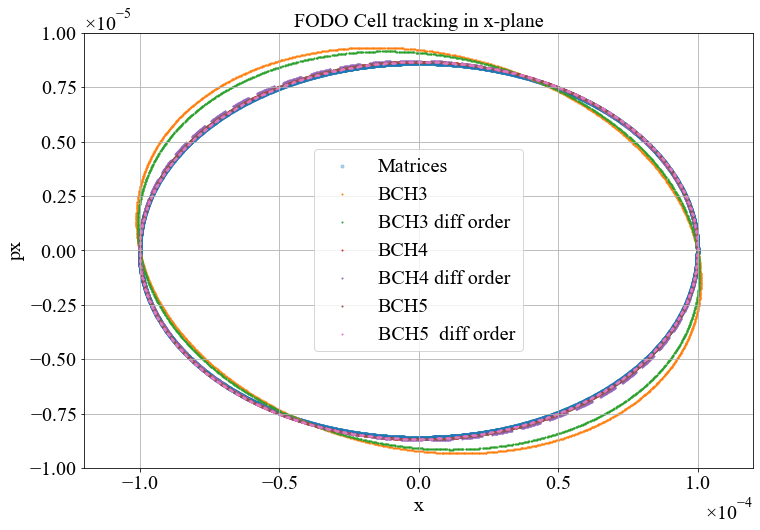

In [34]:
#-----------------------------------Plots----------------------------------------------
fig = plt.figure(figsize=(12,8))

plt.scatter(dataMATRICES[:,0],dataMATRICES[:,1],s=10,alpha=0.3,label='Matrices')

plt.scatter(dataBCH3[:,0],dataBCH3[:,1],s=1,label='BCH3')
plt.scatter(dataBCH3_diff[:,0],dataBCH3_diff[:,1],s=1,label='BCH3 diff order')

plt.scatter(dataBCH4[:,0],dataBCH4[:,1],s=1,label='BCH4')
plt.scatter(dataBCH4_diff[:,0],dataBCH4_diff[:,1],s=1,label='BCH4 diff order')

plt.scatter(dataBCH5[:,0],dataBCH5[:,1],s=1,label='BCH5')
plt.scatter(dataBCH5_diff[:,0],dataBCH5_diff[:,1],s=1,label='BCH5  diff order')


plt.title('FODO Cell tracking in x-plane')
plt.xlabel('x')
plt.ylabel('px')
plt.grid()
plt.xlim(-0.00012,0.00012);
plt.ylim(-0.00001,0.00001);
plt.legend();
plt.savefig('FODOtrackxplane_BCH.png')

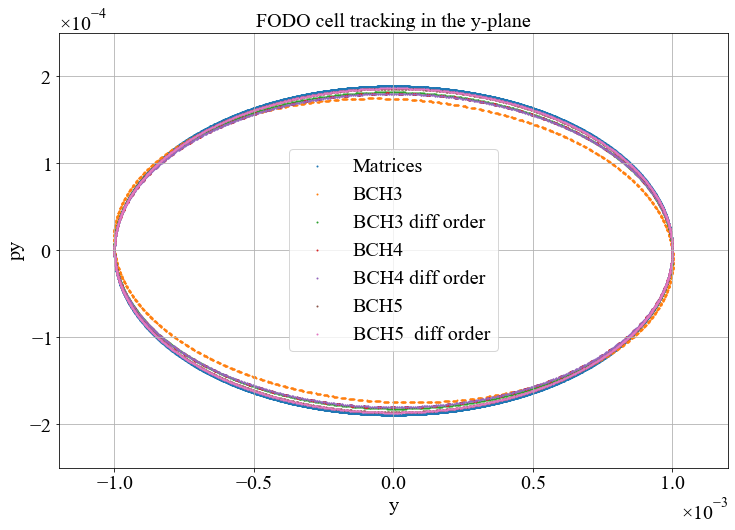

In [21]:
#-----------------------------------Plots----------------------------------------------
fig = plt.figure(figsize=(12,8))

plt.scatter(dataMATRICES[:,2],dataMATRICES[:,3],s=1,label='Matrices')

plt.scatter(dataBCH3[:,2],dataBCH3[:,3],s=1,label='BCH3')
plt.scatter(dataBCH3_diff[:,2],dataBCH3_diff[:,3],s=1,label='BCH3 diff order')

plt.scatter(dataBCH4[:,2],dataBCH4[:,3],s=1,label='BCH4')
plt.scatter(dataBCH4_diff[:,2],dataBCH4_diff[:,3],s=1,label='BCH4 diff order')

plt.scatter(dataBCH5[:,2],dataBCH5[:,3],s=1,label='BCH5')
plt.scatter(dataBCH5_diff[:,2],dataBCH5_diff[:,3],s=1,label='BCH5  diff order')

plt.title('FODO cell tracking in the y-plane')
plt.xlabel('y')
plt.ylabel('py')
plt.grid()
plt.xlim(-0.0012,0.0012);
plt.ylim(-0.00025,0.00025);
plt.legend();
plt.savefig('FODOtrackyplane_BCH.png')

# First order approx for bachelor

In [41]:
R1 = FODOLieMap(0.25,0.5,2.5,0.54102,-0.54102,1)

-3.0*p_x**2
-3.0*p_y**2


/Users/JFrank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/JFrank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/JFrank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/Users/JFrank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


In [43]:
def monomial(r,l):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    xn = x + l * px
    pxn = px
    yn = y + l * py
    pyn = py
    
    return xn, pxn, yn, pyn

In [55]:
l = 6

r0 = np.array([10e-5,0,10e-4,0])

dataBCH1 = [r0]


duration = 1000

for i in range(duration):
    r1_new = monomial(r0,l)


    dataBCH1.append(r1_new)
    r0 = np.copy(r1_new)

dataBCH1 = np.array(dataBCH1)

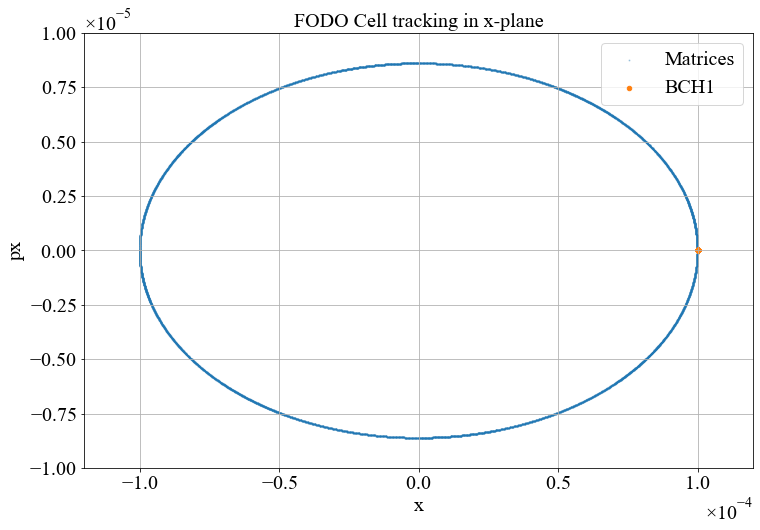

In [60]:
#-----------------------------------Plots----------------------------------------------
fig = plt.figure(figsize=(12,8))

plt.scatter(dataMATRICES[:,0],dataMATRICES[:,1],s=1,alpha=0.3,label='Matrices')

plt.scatter(dataBCH1[:,0],dataBCH1[:,1],s=20,label='BCH1')


plt.title('FODO Cell tracking in x-plane')
plt.xlabel('x')
plt.ylabel('px')
plt.grid()
plt.xlim(-0.00012,0.00012);
plt.ylim(-0.00001,0.00001);
plt.legend();
plt.savefig('FODOtrackxplane_BCH_0order.png')

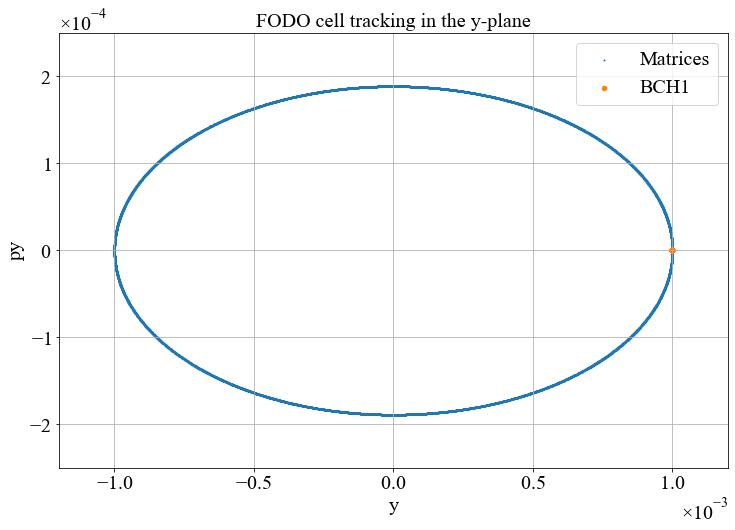

In [61]:
#-----------------------------------Plots----------------------------------------------
fig = plt.figure(figsize=(12,8))

plt.scatter(dataMATRICES[:,2],dataMATRICES[:,3],s=1,label='Matrices')

plt.scatter(dataBCH1[:,2],dataBCH1[:,3],s=20,label='BCH1')


plt.title('FODO cell tracking in the y-plane')
plt.xlabel('y')
plt.ylabel('py')
plt.grid()
plt.xlim(-0.0012,0.0012);
plt.ylim(-0.00025,0.00025);
plt.legend();
plt.savefig('FODOtrackyplane_BCH_0order.png')